In [9]:
pip install torch datasets pandas numpy tqdm scikit-learn tokenizers

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import math
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers.trainers import WordPieceTrainer
from tokenizers.pre_tokenizers import Whitespace
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [11]:
# Disable tokenizer parallelism
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [12]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Category Classification

In [13]:
import os
import math
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tokenizers import ByteLevelBPETokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 32
max_length = 128
num_epochs = 20
learning_rate = 3e-4

Using device: cuda


In [18]:
df = pd.read_csv("cholito_bengali_human_ai_dataset.csv")
df = df[df['category'].isin(['poems', 'stories', 'essays', 'novels'])]  # Filter only valid categories

# Map categories to numerical labels
label_map = {"poems": 0, "stories": 1, "essays": 2, "novels": 3}
df["label"] = df["category"].map(label_map)

texts, labels = df["text"].tolist(), df["label"].tolist()


train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


Total category distribution:
 category
novels     5000
essays     5000
stories    5000
poems      4000
Name: count, dtype: int64


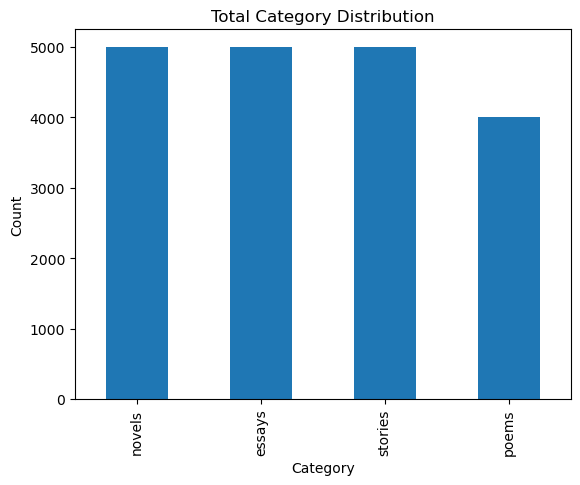

In [27]:
from collections import Counter
import matplotlib.pyplot as plt

# Check category distribution in full dataset
category_counts = df['category'].value_counts()
print("Total category distribution:\n", category_counts)

# Optional: plot
category_counts.plot(kind='bar', title='Total Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()


Train set distribution:
  Class 0: 3200
  Class 1: 4000
  Class 2: 4000
  Class 3: 4000

Validation set distribution:
  Class 0: 400
  Class 1: 500
  Class 2: 500
  Class 3: 500

Test set distribution:
  Class 0: 400
  Class 1: 500
  Class 2: 500
  Class 3: 500



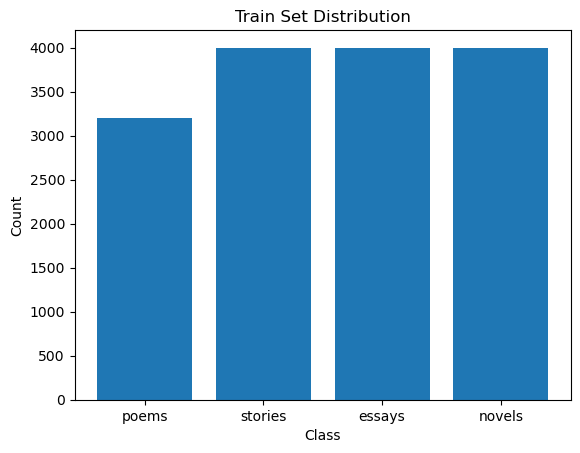

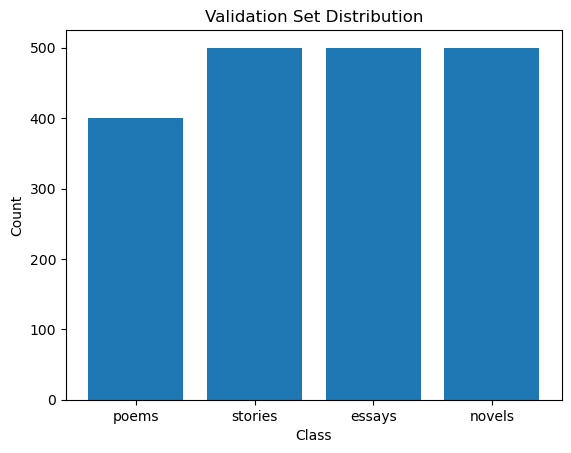

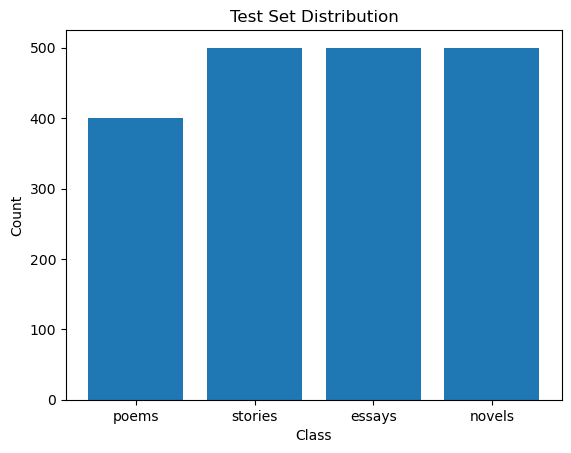

In [30]:
def print_distribution(labels, name):
    counts = Counter(labels)
    print(f"{name} set distribution:")
    for k, v in sorted(counts.items()):
        print(f"  Class {k}: {v}")
    print()

print_distribution(train_labels, "Train")
print_distribution(val_labels, "Validation")
print_distribution(test_labels, "Test")


def plot_distribution(labels, name):
    counts = Counter(labels)
    plt.bar(counts.keys(), counts.values())
    plt.title(f"{name} Set Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(ticks=[0,1,2,3], labels=['poems','stories','essays','novels'])
    plt.show()

plot_distribution(train_labels, "Train")
plot_distribution(val_labels, "Validation")
plot_distribution(test_labels, "Test")


# Tokenizer

In [19]:
if not os.path.exists("bengali_tokenizer"):
    os.makedirs("bengali_tokenizer")  # Ensure the directory exists
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train_from_iterator(train_texts, vocab_size=30000, min_frequency=2, special_tokens=["[PAD]", "[UNK]", "[CLS]", "[SEP]"])
    tokenizer.save_model("bengali_tokenizer")
else:
    tokenizer = ByteLevelBPETokenizer("bengali_tokenizer/vocab.json", "bengali_tokenizer/merges.txt")

def encode_batch(texts):
    encodings = tokenizer.encode_batch(texts)
    input_ids, attention_masks = [], []
    for e in encodings:
        ids = e.ids[:max_length] + [0] * (max_length - len(e.ids)) if len(e.ids) < max_length else e.ids[:max_length]
        mask = [1] * min(len(e.ids), max_length) + [0] * (max_length - len(e.ids))
        input_ids.append(ids)
        attention_masks.append(mask)
    return torch.tensor(input_ids), torch.tensor(attention_masks)

class BengaliTextDataset(Dataset):
    def __init__(self, texts, labels):
        self.input_ids, self.attention_mask = encode_batch(texts)
        self.labels = torch.tensor(labels)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.input_ids[idx],
            "attention_mask": self.attention_mask[idx],
            "labels": self.labels[idx]
        }

train_dataset = BengaliTextDataset(train_texts, train_labels)
val_dataset = BengaliTextDataset(val_texts, val_labels)
test_dataset = BengaliTextDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Custom Class

In [20]:
class CustomTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=128, d_model=512, nhead=8, num_layers=6, dim_feedforward=2048, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(max_len, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout=0.3, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, input_ids, attention_mask):
        positions = torch.arange(0, input_ids.size(1), device=input_ids.device).unsqueeze(0)
        x = self.embedding(input_ids) + self.position_embedding(positions)
        x = self.encoder(x, src_key_padding_mask=~attention_mask.bool())
        x = self.dropout(x[:, 0])  # Take CLS token representation
        return self.classifier(x)


# Training Setup

In [21]:
vocab_size = tokenizer.get_vocab_size()
model = CustomTransformer(vocab_size=vocab_size, num_classes=4).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)

# Scheduler (optional warmup + decay)
from transformers import get_cosine_schedule_with_warmup
warmup_steps = 500
total_steps = len(train_loader) * num_epochs
scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)


In [22]:
def train_epoch():
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def evaluate(loader):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    return total_loss / len(loader), accuracy, all_preds, all_labels

# Training

In [23]:
train_losses = []
val_losses = []
val_accuracies = []
best_val_acc = 0.0
best_epoch = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_epoch()
    val_loss, val_acc, _, _ = evaluate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save model if it improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), "best_classification_category_bengali_transformer.pt")
        print("Saved new best model.")



Epoch 1/20


Training: 100%|██████████████████████████████████████████████████████████████████████| 475/475 [00:34<00:00, 13.63it/s]
C:\Users\Jim\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:508: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. We recommend specifying layout=torch.jagged when constructing a nested tensor, as this layout receives active development, has better operator coverage, and works with torch.compile. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\NestedTensorImpl.cpp:182.)
  output = torch._nested_tensor_from_mask(
Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.07it/s]


Train Loss: 1.1887, Val Loss: 1.0730, Val Acc: 0.5705
Saved new best model.

Epoch 2/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.17it/s]


Train Loss: 1.0109, Val Loss: 0.9729, Val Acc: 0.6037
Saved new best model.

Epoch 3/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.56it/s]


Train Loss: 0.9560, Val Loss: 0.9685, Val Acc: 0.6158
Saved new best model.

Epoch 4/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.80it/s]


Train Loss: 0.9382, Val Loss: 0.9853, Val Acc: 0.6253
Saved new best model.

Epoch 5/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.47it/s]


Train Loss: 0.9332, Val Loss: 1.0118, Val Acc: 0.6089

Epoch 6/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.47it/s]


Train Loss: 0.9479, Val Loss: 1.0952, Val Acc: 0.5216

Epoch 7/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.45it/s]


Train Loss: 0.9502, Val Loss: 1.0122, Val Acc: 0.5958

Epoch 8/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.81it/s]


Train Loss: 0.9783, Val Loss: 1.0414, Val Acc: 0.5968

Epoch 9/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 50.17it/s]


Train Loss: 0.9386, Val Loss: 1.0416, Val Acc: 0.5942

Epoch 10/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.66it/s]


Train Loss: 0.9281, Val Loss: 1.1479, Val Acc: 0.5442

Epoch 11/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.74it/s]


Train Loss: 0.9852, Val Loss: 1.0186, Val Acc: 0.6016

Epoch 12/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.51it/s]


Train Loss: 0.9232, Val Loss: 0.9995, Val Acc: 0.6221

Epoch 13/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.62it/s]


Train Loss: 0.8957, Val Loss: 1.1801, Val Acc: 0.5979

Epoch 14/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.37it/s]


Train Loss: 0.8870, Val Loss: 1.0789, Val Acc: 0.5763

Epoch 15/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.43it/s]


Train Loss: 0.8757, Val Loss: 0.9929, Val Acc: 0.6405
Saved new best model.

Epoch 16/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.49it/s]


Train Loss: 0.8655, Val Loss: 1.0553, Val Acc: 0.5968

Epoch 17/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.42it/s]


Train Loss: 0.8607, Val Loss: 0.9740, Val Acc: 0.6316

Epoch 18/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.59it/s]


Train Loss: 0.8540, Val Loss: 0.9951, Val Acc: 0.6163

Epoch 19/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.55it/s]


Train Loss: 0.8495, Val Loss: 0.9928, Val Acc: 0.6274

Epoch 20/20


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.83it/s]

Train Loss: 0.8516, Val Loss: 0.9909, Val Acc: 0.6289


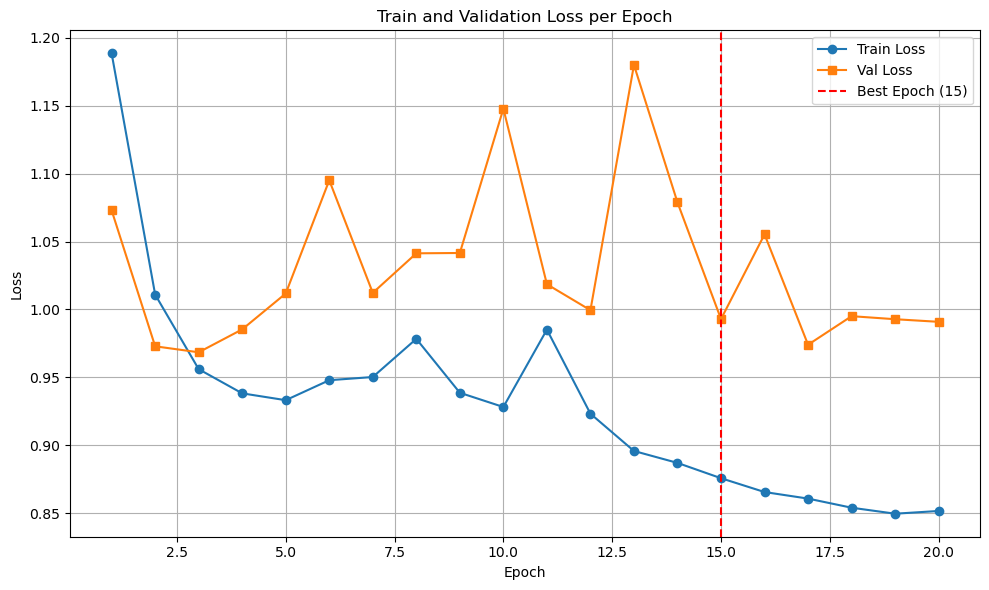

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Val Loss', marker='s')
plt.axvline(x=best_epoch + 1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch + 1})')

plt.title("Train and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
import torch

# Load best model weights
model.load_state_dict(torch.load("best_classification_category_bengali_transformer.pt"))
model.eval()

# Evaluate on test set
test_loss, test_acc, test_preds, test_labels = evaluate(test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Evaluating: 100%|██████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 49.80it/s]

Test Loss: 1.0178, Test Accuracy: 0.6295


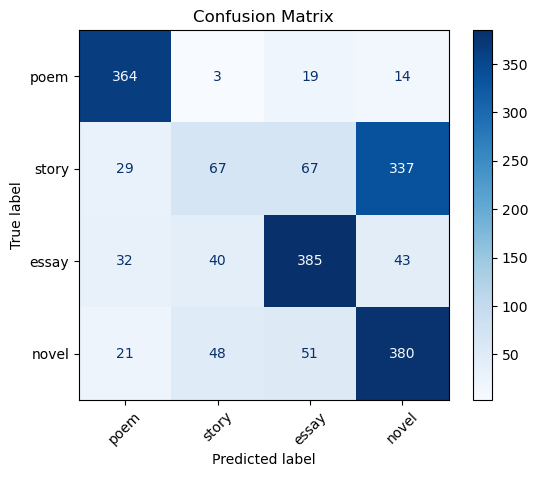

Classification Report:
              precision    recall  f1-score   support

        poem     0.8161    0.9100    0.8605       400
       story     0.4241    0.1340    0.2036       500
       essay     0.7375    0.7700    0.7534       500
       novel     0.4910    0.7600    0.5965       500

    accuracy                         0.6295      1900
   macro avg     0.6172    0.6435    0.6035      1900
weighted avg     0.6067    0.6295    0.5900      1900



In [26]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert predictions and labels to numpy arrays (if not already)
test_preds = test_preds.cpu().numpy() if hasattr(test_preds, "cpu") else test_preds
test_labels = test_labels.cpu().numpy() if hasattr(test_labels, "cpu") else test_labels

# Define class names
class_names = ["poem", "story", "essay", "novel"]


# Plot confusion matrix with labels
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Print classification report with label names
print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))
